<a href="https://www.kaggle.com/code/andir16/rsna-2022-sagittal-view?scriptVersionId=118334655" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>1 Intro/Context</b></p>
</div>

This notebook is an attempt at stacking all dcm files of one patient to create an nii file to extract the sagittal view. This is done because not all patients have segmentation data (no nii file) and therefore vertebrae detection needs to be approached differently.

For the full EDA check out: https://www.kaggle.com/code/andir16/rsna-2022-cervical-spine-fracture-detection-eda

I am still tweaking and working on it. But I already wanted to share the progress with you.

Feedback and input is very much appreciated. 

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>2 Libraries / Setup</b></p>
</div>


In [1]:
!pip install dicom2nifti

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 337.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.9 MB/s eta 0:00:00


In [2]:
import os
import pydicom
import dicom2nifti
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from pydicom.datadict import dictionary_VR


<hr>

In [3]:
patient_id = "1.2.826.0.1.3680043.10449"
base_path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/"

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>3 DICOM Metadata</b></p>
</div>

We will use the [dicom2nifti](https://dicom2nifti.readthedocs.io/en/latest/index.html) library to convert the dicom images to one nii image. However, dicom2nifti needs specific values in the metadata, one of which is the type of scan (modality) that the image contains. This is not included in the metadata of the training images.

In [4]:
example_path = f"{base_path}{patient_id}/1.dcm"

dcm_example = pydicom.dcmread(example_path)
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10449.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10449.1.1
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183115.811051'
(0010, 0010) Patient's Name                      PN: '10449'
(0010, 0020) Patient ID                          LO: '10449'
(0018, 0050) Slice Thickness                     DS: '0.5'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0.1.3

<hr>

The modality entry is (0008, 0060) [(DICOM Modalities)](http://dicomlookup.com/modalities.asp) and the dictionary entry is "CS". 

In [5]:
dictionary_VR([0x0008, 0x0060])

'CS'

With this information we can add the modality entry for the CT scan to the metadata:

In [6]:
dcm_example.add_new([0x0008, 0x0060], "CS", "CT")
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10449.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10449.1.1
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183115.811051'
(0008, 0060) Modality                            CS: 'CT'
(0010, 0010) Patient's Name                      PN: '10449'
(0010, 0020) Patient ID                          LO: '10449'
(0018, 0050) Slice Thickness                     DS: '0.5'
(0020, 0

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>4 Edit/Export DICOM Files</b></p>
</div>

Because we need to add the modality information to all dcm images, a working folder is created and all images for one patient are edited (adds the modality entry) and exported to that folder. 

In [7]:
export_dir = "/kaggle/working/dcm_export"

# Create export folder for one patient
os.mkdir(export_dir)

In [8]:
image_nr = 1

patient_path = f"{base_path}{patient_id}/"

for filename in os.listdir(patient_path):
    path = patient_path + str(image_nr) + ".dcm"
    dcm_example = pydicom.dcmread(path)
    dcm_example.add_new([0x0008, 0x0060], "CS", "CT")
    pydicom.filewriter.write_file(f"{export_dir}/{image_nr}.dcm", dcm_example, write_like_original=True)
    image_nr += 1

print(f"Saved {image_nr-1} images")

Saved 466 images


<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>5 Create nii File</b></p>
</div>

We use [SimpleITK](https://simpleitk.org/) to create the nii file from the exported dcm images, then import the created nii file and prepare it according to the post by [Harshit Sheoran](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340612)

In [9]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(export_dir)
reader.SetFileNames(dicom_names)
image = reader.Execute()
image = sitk.PermuteAxes(image, [2, 1, 0])

sitk.WriteImage(image, f"{patient_id}.nii.gz")

In [10]:
# From https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340612
example_path_nii = f"{patient_id}.nii.gz"
nii_example = nib.load(example_path_nii)
data = nii_example.get_fdata()

data_transposed = data[:, ::-1, ::-1].transpose(2, 1, 0)
data_transposed.shape

(512, 512, 466)

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>6 Display Sagittal View</b></p>
</div>

We define the middle slice (based on the number of images) and display this slice to get the sagittal view.

In [11]:
middle_point = int(data_transposed.shape[2] / 2)
print(middle_point)

233


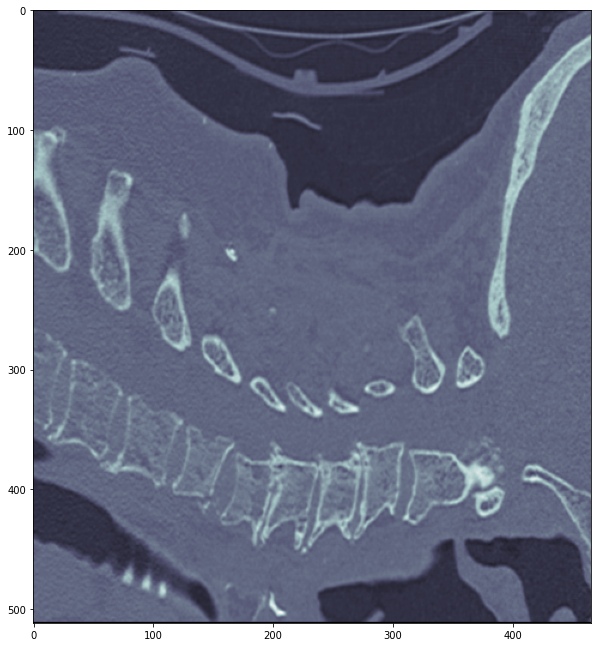

In [12]:
plt.figure(figsize=(10,15))

plt.imshow(data_transposed[middle_point], cmap='bone')

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>7 References</b></p>
</div>

* [RSNA 2022 Cervical Spine Fracture Detection - EDA](https://www.kaggle.com/code/andir16/rsna-2022-cervical-spine-fracture-detection-eda) by [Andreas Renz](https://www.kaggle.com/andir16)
* [Explaining Data and Submission in detail](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340612) by [Harshit Sheoran](https://www.kaggle.com/harshitsheoran)